# Speech Recognition dengan DTW dan HMM
## Tugas Akhir - Pengenalan Ucapan

**Tujuan**: Implementasi sistem speech recognition untuk kontrol kendaraan menggunakan teknik DTW (Dynamic Time Warping) dan HMM (Hidden Markov Models)

**Vocabulary**: "gas", "rem", "belok", "mundur", "nyalakan", "matikan"

**Dataset**: 3 speaker (Bayu, Davney, Faturohman) dengan struktur:
```
data/
├── training/
│   ├── Dataset Bayu/
│   ├── Dataset Davney/
│   └── Dataset Faturohman/
└── testing/
    ├── Dataset Bayu/
    ├── Dataset Davney/
    └── Dataset Faturohman/
```

**Metrik Evaluasi**: Precision, Recall, F1-Score, Accuracy

In [1]:
# ========================================================================================
# 1. IMPORT LIBRARIES DAN KONFIGURASI
# ========================================================================================

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pickle
import warnings
warnings.filterwarnings('ignore')

# Konfigurasi plot
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Library berhasil diimport!")
print("📊 Konfigurasi plot berhasil diatur!")

# Konfigurasi global
VOCABULARY = ["gas", "rem", "belok", "mundur", "nyalakan", "matikan"]
SPEAKERS = ["Dataset Bayu", "Dataset Davney", "Dataset Faturohman"]
SAMPLING_RATE = 22050
N_MFCC = 13
HOP_LENGTH = 512
N_FFT = 2048

print(f"🎯 Vocabulary: {VOCABULARY}")
print(f"👥 Expected Speakers: {SPEAKERS}")
print(f"🔊 Audio Config: SR={SAMPLING_RATE}, MFCC={N_MFCC}")

✅ Library berhasil diimport!
📊 Konfigurasi plot berhasil diatur!
🎯 Vocabulary: ['gas', 'rem', 'belok', 'mundur', 'nyalakan', 'matikan']
👥 Expected Speakers: ['Dataset Bayu', 'Dataset Davney', 'Dataset Faturohman']
🔊 Audio Config: SR=22050, MFCC=13


In [2]:
# ========================================================================================
# 2. FUNGSI UTILITAS DATASET
# ========================================================================================

def check_dataset_structure():
    """Mengecek keberadaan dan struktur dataset"""
    base_paths = ['data/training', 'data/testing']
    results = {'training': {}, 'testing': {}}
    
    for phase in ['training', 'testing']:
        path = f'data/{phase}'
        print(f"\n📁 Checking {phase} dataset...")
        
        if not os.path.exists(path):
            print(f"❌ Path {path} tidak ditemukan!")
            results[phase] = {}
            continue
            
        for speaker in SPEAKERS:
            speaker_path = os.path.join(path, speaker)
            if os.path.exists(speaker_path):
                print(f"✅ {speaker} ditemukan")
                word_count = {}
                for word in VOCABULARY:
                    word_path = os.path.join(speaker_path, word)
                    if os.path.exists(word_path):
                        audio_files = [f for f in os.listdir(word_path) if f.endswith('.wav')]
                        word_count[word] = len(audio_files)
                    else:
                        word_count[word] = 0
                results[phase][speaker] = word_count
            else:
                print(f"⚠️ {speaker} tidak ditemukan di {phase}")
                results[phase][speaker] = None
    
    return results

def explore_speaker_dataset(speaker_name, phase='training'):
    """Eksplorasi detail dataset per speaker"""
    speaker_path = f'data/{phase}/{speaker_name}'
    
    if not os.path.exists(speaker_path):
        print(f"❌ Speaker {speaker_name} tidak ditemukan di {phase}")
        return None
    
    print(f"\n🔍 Detail dataset {speaker_name} ({phase}):")
    print("-" * 50)
    
    total_files = 0
    for word in VOCABULARY:
        word_path = os.path.join(speaker_path, word)
        if os.path.exists(word_path):
            files = [f for f in os.listdir(word_path) if f.endswith('.wav')]
            print(f"📢 {word:10}: {len(files):2} file(s)")
            total_files += len(files)
        else:
            print(f"📢 {word:10}: 0 file(s) (folder tidak ada)")
    
    print(f"\n📊 Total file audio: {total_files}")
    return total_files

def load_dataset(speaker_names=None, phases=['training'], limit_per_word=None):
    """Load dataset dengan opsi filter speaker dan limit file"""
    if speaker_names is None:
        speaker_names = SPEAKERS
    
    dataset = {'training': {}, 'testing': {}}
    
    for phase in phases:
        print(f"\n📥 Loading {phase} dataset...")
        dataset[phase] = {}
        
        for speaker in speaker_names:
            speaker_path = f'data/{phase}/{speaker}'
            if not os.path.exists(speaker_path):
                print(f"⚠️ Speaker {speaker} tidak tersedia di {phase}, skip...")
                continue
                
            print(f"   👤 Loading {speaker}...")
            dataset[phase][speaker] = {}
            
            for word in VOCABULARY:
                word_path = os.path.join(speaker_path, word)
                if not os.path.exists(word_path):
                    dataset[phase][speaker][word] = []
                    continue
                
                audio_files = [f for f in os.listdir(word_path) if f.endswith('.wav')]
                if limit_per_word:
                    audio_files = audio_files[:limit_per_word]
                
                dataset[phase][speaker][word] = []
                for audio_file in audio_files:
                    file_path = os.path.join(word_path, audio_file)
                    dataset[phase][speaker][word].append(file_path)
                
                print(f"      📢 {word}: {len(dataset[phase][speaker][word])} files")
    
    return dataset

# Test fungsi
print("🧪 Testing dataset management functions...")
dataset_info = check_dataset_structure()

🧪 Testing dataset management functions...

📁 Checking training dataset...
✅ Dataset Bayu ditemukan
✅ Dataset Davney ditemukan
✅ Dataset Faturohman ditemukan

📁 Checking testing dataset...
✅ Dataset Bayu ditemukan
✅ Dataset Davney ditemukan
✅ Dataset Faturohman ditemukan


In [3]:
# ========================================================================================
# 3. FUNGSI EKSTRAKSI FITUR
# ========================================================================================

def extract_mfcc_features(audio_path, n_mfcc=N_MFCC, duration=None):
    """Ekstraksi fitur MFCC untuk DTW"""
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=SAMPLING_RATE, duration=duration)
        
        # Ekstraksi MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, 
                                   hop_length=HOP_LENGTH, n_fft=N_FFT)
        
        # Transpose untuk format (time_steps, features)
        mfcc = mfcc.T
        
        return mfcc
    except Exception as e:
        print(f"❌ Error loading {audio_path}: {e}")
        return None

def extract_enhanced_features(audio_path, n_mfcc=N_MFCC):
    """Ekstraksi fitur enhanced (MFCC + Delta + Delta-Delta) untuk HMM"""
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=SAMPLING_RATE)
        
        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                                   hop_length=HOP_LENGTH, n_fft=N_FFT)
        
        # Delta dan Delta-Delta
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # Gabungkan semua fitur
        features = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
        
        # Transpose untuk format (time_steps, features)
        features = features.T
        
        return features
    except Exception as e:
        print(f"❌ Error loading {audio_path}: {e}")
        return None

def compute_dtw_distance(template, test_sample):
    """Hitung jarak DTW antara template dan test sample"""
    try:
        from fastdtw import fastdtw
        distance, _ = fastdtw(template, test_sample, dist=euclidean)
        return distance
    except ImportError:
        print("⚠️ fastdtw tidak tersedia, menggunakan implementasi manual...")
        # Implementasi DTW sederhana manual
        return manual_dtw_distance(template, test_sample)

def manual_dtw_distance(template, test_sample):
    """Implementasi DTW manual sederhana"""
    n, m = len(template), len(test_sample)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = euclidean(template[i-1], test_sample[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],      # insertion
                                         dtw_matrix[i, j-1],      # deletion
                                         dtw_matrix[i-1, j-1])    # match
    
    return dtw_matrix[n, m]

def visualize_features(audio_path, title="Audio Features"):
    """Visualisasi fitur audio"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Load audio
    y, sr = librosa.load(audio_path, sr=SAMPLING_RATE)
    
    # Waveform
    axes[0, 0].plot(np.linspace(0, len(y)/sr, len(y)), y)
    axes[0, 0].set_title('Waveform')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=axes[0, 1])
    axes[0, 1].set_title('Spectrogram')
    
    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    librosa.display.specshow(mfcc, x_axis='time', ax=axes[1, 0])
    axes[1, 0].set_title('MFCC')
    
    # Enhanced features
    enhanced = extract_enhanced_features(audio_path)
    if enhanced is not None:
        librosa.display.specshow(enhanced.T, x_axis='time', ax=axes[1, 1])
        axes[1, 1].set_title('Enhanced Features (MFCC + Delta)')
    
    plt.suptitle(f'{title} - {os.path.basename(audio_path)}')
    plt.tight_layout()
    plt.show()

print("🎵 Feature extraction functions ready!")
print("📊 Available functions:")
print("   - extract_mfcc_features(): For DTW")
print("   - extract_enhanced_features(): For HMM") 
print("   - compute_dtw_distance(): DTW distance calculation")
print("   - visualize_features(): Feature visualization")

🎵 Feature extraction functions ready!
📊 Available functions:
   - extract_mfcc_features(): For DTW
   - extract_enhanced_features(): For HMM
   - compute_dtw_distance(): DTW distance calculation
   - visualize_features(): Feature visualization


In [4]:
# ========================================================================================
# 4. DTW SPEECH RECOGNIZER
# ========================================================================================

class DTWSpeechRecognizer:
    def __init__(self, vocabulary=VOCABULARY):
        self.vocabulary = vocabulary
        self.templates = {}
        self.is_trained = False
        
    def train(self, training_data):
        """Train DTW recognizer dengan membuat template untuk setiap kata"""
        print("🔧 Training DTW Speech Recognizer...")
        self.templates = {}
        
        # Untuk setiap kata dalam vocabulary
        for word in self.vocabulary:
            print(f"   📢 Processing word: {word}")
            word_templates = []
            
            # Kumpulkan semua file audio untuk kata ini dari semua speaker
            for speaker in training_data:
                if word in training_data[speaker]:
                    for audio_path in training_data[speaker][word]:
                        features = extract_mfcc_features(audio_path)
                        if features is not None:
                            word_templates.append(features)
            
            if word_templates:
                # Untuk DTW, kita simpan semua template (tidak di-average)
                self.templates[word] = word_templates
                print(f"      ✅ {len(word_templates)} templates for '{word}'")
            else:
                print(f"      ❌ No valid templates for '{word}'")
        
        self.is_trained = True
        print(f"✅ DTW training completed! Templates for {len(self.templates)} words.")
        
    def predict(self, audio_path):
        """Prediksi kata menggunakan DTW"""
        if not self.is_trained:
            raise Exception("Model belum di-training!")
        
        # Ekstraksi fitur dari audio test
        test_features = extract_mfcc_features(audio_path)
        if test_features is None:
            return None, None
        
        min_distance = float('inf')
        predicted_word = None
        distances = {}
        
        # Hitung jarak DTW untuk setiap kata
        for word in self.vocabulary:
            if word not in self.templates:
                continue
                
            word_distances = []
            # Bandingkan dengan semua template untuk kata ini
            for template in self.templates[word]:
                distance = compute_dtw_distance(template, test_features)
                word_distances.append(distance)
            
            # Ambil jarak minimum untuk kata ini
            if word_distances:
                min_word_distance = min(word_distances)
                distances[word] = min_word_distance
                
                if min_word_distance < min_distance:
                    min_distance = min_word_distance
                    predicted_word = word
        
        return predicted_word, distances
    
    def evaluate(self, test_data, verbose=True):
        """Evaluasi performa model pada test data"""
        if not self.is_trained:
            raise Exception("Model belum di-training!")
        
        if verbose:
            print("📊 Evaluating DTW model...")
        y_true = []
        y_pred = []
        detailed_results = []
        
        for speaker in test_data:
            if verbose:
                print(f"   👤 DTW Testing speaker: {speaker}")
            for true_word in self.vocabulary:
                if true_word in test_data[speaker]:
                    for audio_path in test_data[speaker][true_word]:
                        predicted_word, distances = self.predict(audio_path)
                        
                        y_true.append(true_word)
                        y_pred.append(predicted_word if predicted_word else "UNKNOWN")
                        
                        detailed_results.append({
                            'speaker': speaker,
                            'true_word': true_word,
                            'predicted_word': predicted_word,
                            'audio_path': audio_path,
                            'distances': distances
                        })
        
        # Hitung metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, 
                                                                  average='weighted', 
                                                                  zero_division=0)
        
        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_true': y_true,
            'y_pred': y_pred,
            'detailed_results': detailed_results
        }
        
        if verbose:
            print(f"   ✅ DTW Accuracy: {accuracy:.3f}")
            print(f"   ✅ DTW Precision: {precision:.3f}")
            print(f"   ✅ DTW Recall: {recall:.3f}")
            print(f"   ✅ DTW F1-Score: {f1:.3f}")
        
        return results
    
    def save_model(self, filepath):
        """Simpan model DTW"""
        model_data = {
            'vocabulary': self.vocabulary,
            'templates': self.templates,
            'is_trained': self.is_trained
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"💾 DTW model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load model DTW"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.vocabulary = model_data['vocabulary']
        self.templates = model_data['templates']
        self.is_trained = model_data['is_trained']
        print(f"📁 DTW model loaded from {filepath}")

print("🤖 DTW Speech Recognizer class ready!")
print("📋 Available methods:")
print("   - train(): Train with templates")
print("   - predict(): Recognize speech")
print("   - evaluate(): Test performance")
print("   - save_model()/load_model(): Model persistence")

🤖 DTW Speech Recognizer class ready!
📋 Available methods:
   - train(): Train with templates
   - predict(): Recognize speech
   - evaluate(): Test performance
   - save_model()/load_model(): Model persistence


In [5]:
# ========================================================================================
# 5. HMM SPEECH RECOGNIZER
# ========================================================================================

class HMMSpeechRecognizer:
    def __init__(self, vocabulary=VOCABULARY, n_components=5):
        self.vocabulary = vocabulary
        self.n_components = n_components
        self.models = {}
        self.is_trained = False
        
    def train(self, training_data):
        """Train HMM recognizer untuk setiap kata"""
        print("🔧 Training HMM Speech Recognizer...")
        
        try:
            from hmmlearn import hmm
        except ImportError:
            print("❌ hmmlearn tidak tersedia. Install dengan: pip install hmmlearn")
            return
        
        self.models = {}
        
        # Untuk setiap kata dalam vocabulary
        for word in self.vocabulary:
            print(f"   📢 Training HMM for word: {word}")
            
            # Kumpulkan semua fitur untuk kata ini
            all_features = []
            lengths = []
            
            for speaker in training_data:
                if word in training_data[speaker]:
                    for audio_path in training_data[speaker][word]:
                        features = extract_enhanced_features(audio_path)
                        if features is not None:
                            all_features.append(features)
                            lengths.append(len(features))
            
            if all_features:
                # Gabungkan semua fitur
                X = np.vstack(all_features)
                
                # Train Gaussian HMM
                model = hmm.GaussianHMM(n_components=self.n_components, 
                                       covariance_type="diag",
                                       n_iter=100,
                                       random_state=42)
                
                try:
                    model.fit(X, lengths)
                    self.models[word] = model
                    print(f"      ✅ HMM trained for '{word}' with {len(all_features)} samples")
                except Exception as e:
                    print(f"      ❌ Failed to train HMM for '{word}': {e}")
            else:
                print(f"      ❌ No valid features for '{word}'")
        
        self.is_trained = True
        print(f"✅ HMM training completed! Models for {len(self.models)} words.")
        
    def predict(self, audio_path):
        """Prediksi kata menggunakan HMM"""
        if not self.is_trained:
            raise Exception("Model belum di-training!")
        
        # Ekstraksi fitur dari audio test
        test_features = extract_enhanced_features(audio_path)
        if test_features is None:
            return None, None
        
        max_score = float('-inf')
        predicted_word = None
        scores = {}
        
        # Hitung likelihood untuk setiap model HMM
        for word in self.vocabulary:
            if word not in self.models:
                continue
            
            try:
                score = self.models[word].score(test_features)
                scores[word] = score
                
                if score > max_score:
                    max_score = score
                    predicted_word = word
                    
            except Exception as e:
                print(f"⚠️ Error predicting with HMM for '{word}': {e}")
                scores[word] = float('-inf')
        
        return predicted_word, scores
    
    def evaluate(self, test_data, verbose=True):
        """Evaluasi performa model pada test data"""
        if not self.is_trained:
            raise Exception("Model belum di-training!")
        
        if verbose:
            print("📊 Evaluating HMM model...")
        y_true = []
        y_pred = []
        detailed_results = []
        
        for speaker in test_data:
            if verbose:
                print(f"   👤 HMM Testing speaker: {speaker}")
            for true_word in self.vocabulary:
                if true_word in test_data[speaker]:
                    for audio_path in test_data[speaker][true_word]:
                        predicted_word, scores = self.predict(audio_path)
                        
                        y_true.append(true_word)
                        y_pred.append(predicted_word if predicted_word else "UNKNOWN")
                        
                        detailed_results.append({
                            'speaker': speaker,
                            'true_word': true_word,
                            'predicted_word': predicted_word,
                            'audio_path': audio_path,
                            'scores': scores
                        })
        
        # Hitung metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, 
                                                                  average='weighted', 
                                                                  zero_division=0)
        
        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_true': y_true,
            'y_pred': y_pred,
            'detailed_results': detailed_results
        }
        
        if verbose:
            print(f"   ✅ HMM Accuracy: {accuracy:.3f}")
            print(f"   ✅ HMM Precision: {precision:.3f}")
            print(f"   ✅ HMM Recall: {recall:.3f}")
            print(f"   ✅ HMM F1-Score: {f1:.3f}")
        
        return results
    
    def save_model(self, filepath):
        """Simpan model HMM"""
        model_data = {
            'vocabulary': self.vocabulary,
            'n_components': self.n_components,
            'models': self.models,
            'is_trained': self.is_trained
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"💾 HMM model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load model HMM"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.vocabulary = model_data['vocabulary']
        self.n_components = model_data['n_components']
        self.models = model_data['models']
        self.is_trained = model_data['is_trained']
        print(f"📁 HMM model loaded from {filepath}")

print("🤖 HMM Speech Recognizer class ready!")
print("📋 Available methods:")
print("   - train(): Train HMM models") 
print("   - predict(): Recognize speech")
print("   - evaluate(): Test performance")
print("   - save_model()/load_model(): Model persistence")

🤖 HMM Speech Recognizer class ready!
📋 Available methods:
   - train(): Train HMM models
   - predict(): Recognize speech
   - evaluate(): Test performance
   - save_model()/load_model(): Model persistence


In [6]:
# ========================================================================================
# 6. FUNGSI VISUALISASI DAN EVALUASI
# ========================================================================================

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", labels=None):
    """Plot confusion matrix"""
    if labels is None:
        labels = VOCABULARY
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return cm

def compare_models_performance(dtw_results, hmm_results):
    """Perbandingan performa DTW vs HMM"""
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    dtw_scores = [dtw_results[metric] for metric in metrics]
    hmm_scores = [hmm_results[metric] for metric in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, dtw_scores, width, label='DTW', alpha=0.8)
    bars2 = ax.bar(x + width/2, hmm_scores, width, label='HMM', alpha=0.8)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Perbandingan Performa DTW vs HMM')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
    ax.legend()
    ax.set_ylim(0, 1)
    
    # Tambahkan nilai di atas bar
    def autolabel(bars, scores):
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            ax.annotate(f'{score:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(bars1, dtw_scores)
    autolabel(bars2, hmm_scores)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_results(results, title="Detailed Results"):
    """Plot hasil detail per speaker dan kata"""
    detailed = results['detailed_results']
    
    # Accuracy per speaker
    speaker_accuracy = {}
    for result in detailed:
        speaker = result['speaker']
        if speaker not in speaker_accuracy:
            speaker_accuracy[speaker] = {'correct': 0, 'total': 0}
        
        if result['true_word'] == result['predicted_word']:
            speaker_accuracy[speaker]['correct'] += 1
        speaker_accuracy[speaker]['total'] += 1
    
    # Plot accuracy per speaker
    speakers = list(speaker_accuracy.keys())
    accuracies = [speaker_accuracy[s]['correct'] / speaker_accuracy[s]['total'] 
                 for s in speakers]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(speakers, accuracies, alpha=0.7)
    plt.title(f'{title} - Accuracy per Speaker')
    plt.xlabel('Speaker')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Tambahkan nilai di atas bar
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Accuracy per word
    word_accuracy = {}
    for result in detailed:
        word = result['true_word']
        if word not in word_accuracy:
            word_accuracy[word] = {'correct': 0, 'total': 0}
        
        if result['true_word'] == result['predicted_word']:
            word_accuracy[word]['correct'] += 1
        word_accuracy[word]['total'] += 1
    
    words = list(word_accuracy.keys())
    word_accs = [word_accuracy[w]['correct'] / word_accuracy[w]['total'] 
                for w in words]
    
    plt.subplot(1, 2, 2)
    bars = plt.bar(words, word_accs, alpha=0.7, color='orange')
    plt.title(f'{title} - Accuracy per Word')
    plt.xlabel('Word')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    
    # Tambahkan nilai di atas bar
    for bar, acc in zip(bars, word_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_classification_report(y_true, y_pred, title="Classification Report"):
    """Print laporan klasifikasi detail"""
    print(f"\n📊 {title}")
    print("=" * 60)
    print(classification_report(y_true, y_pred, zero_division=0))

def save_results(dtw_results, hmm_results, filename="speech_recognition_results.pkl"):
    """Simpan hasil evaluasi"""
    results = {
        'dtw_results': dtw_results,
        'hmm_results': hmm_results,
        'vocabulary': VOCABULARY,
        'timestamp': np.datetime64('now')
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"💾 Results saved to {filename}")
    
    # Simpan juga dalam format text
    text_filename = filename.replace('.pkl', '.txt')
    with open(text_filename, 'w') as f:
        f.write("SPEECH RECOGNITION RESULTS\\n")
        f.write("=" * 50 + "\\n\\n")
        
        f.write("DTW RESULTS:\\n")
        f.write(f"Accuracy: {dtw_results['accuracy']:.3f}\\n")
        f.write(f"Precision: {dtw_results['precision']:.3f}\\n")
        f.write(f"Recall: {dtw_results['recall']:.3f}\\n")
        f.write(f"F1-Score: {dtw_results['f1_score']:.3f}\\n\\n")
        
        f.write("HMM RESULTS:\\n")
        f.write(f"Accuracy: {hmm_results['accuracy']:.3f}\\n")
        f.write(f"Precision: {hmm_results['precision']:.3f}\\n")
        f.write(f"Recall: {hmm_results['recall']:.3f}\\n")
        f.write(f"F1-Score: {hmm_results['f1_score']:.3f}\\n")
    
    print(f"📄 Text summary saved to {text_filename}")

print("📊 Visualization and evaluation functions ready!")
print("🎯 Available functions:")
print("   - plot_confusion_matrix(): Confusion matrix visualization")
print("   - compare_models_performance(): DTW vs HMM comparison")
print("   - plot_detailed_results(): Per-speaker and per-word analysis")
print("   - print_classification_report(): Detailed classification metrics")
print("   - save_results(): Save evaluation results")

📊 Visualization and evaluation functions ready!
🎯 Available functions:
   - plot_confusion_matrix(): Confusion matrix visualization
   - compare_models_performance(): DTW vs HMM comparison
   - plot_detailed_results(): Per-speaker and per-word analysis
   - print_classification_report(): Detailed classification metrics
   - save_results(): Save evaluation results


In [7]:
# ========================================================================================
# 7. INSTALASI PACKAGES YANG DIPERLUKAN
# ========================================================================================

import subprocess
import sys

def install_package(package):
    """Install package menggunakan pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} berhasil diinstall")
    except subprocess.CalledProcessError:
        print(f"❌ Gagal install {package}")

# List packages yang diperlukan
required_packages = [
    "librosa",
    "scikit-learn", 
    "seaborn",
    "matplotlib",
    "fastdtw",
    "hmmlearn",
    "soundfile"
]

print("📦 Checking and installing required packages...")
print("=" * 50)

for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"✅ {package} sudah terinstall")
    except ImportError:
        print(f"⚠️ {package} belum terinstall, installing...")
        install_package(package)

print("\\n🎉 Package installation check completed!")

📦 Checking and installing required packages...
✅ librosa sudah terinstall
⚠️ scikit-learn belum terinstall, installing...
✅ scikit-learn berhasil diinstall
✅ seaborn sudah terinstall
✅ matplotlib sudah terinstall
✅ fastdtw sudah terinstall
✅ hmmlearn sudah terinstall
✅ soundfile sudah terinstall
\n🎉 Package installation check completed!


In [8]:
# ========================================================================================
# 8. LOAD DAN EKSPLORASI DATASET
# ========================================================================================

print("🔍 EKSPLORASI STRUKTUR DATASET")
print("=" * 50)

# Cek struktur dataset
dataset_info = check_dataset_structure()

print("\n📊 RINGKASAN KETERSEDIAAN DATASET:")
print("-" * 40)

available_speakers = []
missing_datasets = []

for phase in ['training', 'testing']:
    print(f"\n{phase.upper()}:")
    for speaker in SPEAKERS:
        if speaker in dataset_info[phase] and dataset_info[phase][speaker] is not None:
            if speaker not in available_speakers:
                available_speakers.append(speaker)
            print(f"✅ {speaker} tersedia")
            total_files = sum(dataset_info[phase][speaker].values())
            print(f"   📁 Total file: {total_files}")
        else:
            if speaker not in missing_datasets:
                missing_datasets.append(speaker)
            print(f"❌ {speaker} TIDAK TERSEDIA")
            if speaker == "Dataset Faturohman":
                print("   ⚠️ Dataset Faturohman belum ada - tidak akan dibuat otomatis")
                print("   💡 Silakan tambahkan dataset ini secara manual jika diperlukan")

print(f"\n👥 Speaker yang tersedia: {available_speakers}")
print(f"❌ Dataset yang tidak tersedia: {missing_datasets}")

if not available_speakers:
    print("\n❌ TIDAK ADA DATASET YANG TERSEDIA!")
    print("   Pastikan struktur folder sesuai dengan:")
    print("   data/training/[Dataset Speaker]/[word]/audio_files.wav")
    print("   data/testing/[Dataset Speaker]/[word]/audio_files.wav")
    print("   \n⚠️ SISTEM TIDAK AKAN MEMBUAT DATASET OTOMATIS")
    print("   📝 Anda harus menyediakan dataset sendiri")
else:
    print(f"\n✅ Akan menggunakan {len(available_speakers)} speaker untuk training dan testing")
    
    if missing_datasets:
        print(f"\n⚠️ PERINGATAN: Dataset yang tidak tersedia akan diabaikan")
        print(f"   - Dataset missing: {', '.join(missing_datasets)}")
        print("   - Sistem hanya akan menggunakan dataset yang ada")
        print("   - Tidak ada data sintetis yang dibuat")
    
    # Eksplorasi detail untuk setiap speaker yang tersedia
    print("\n🔍 DETAIL DATASET PER SPEAKER:")
    print("-" * 40)
    
    for speaker in available_speakers:
        print(f"\n📊 Menganalisis {speaker}...")
        explore_speaker_dataset(speaker, 'training')
        if os.path.exists(f'data/testing/{speaker}'):
            explore_speaker_dataset(speaker, 'testing')
        else:
            print(f"   ⚠️ Data testing untuk {speaker} tidak ditemukan")

print("\n🔒 KEBIJAKAN DATASET:")
print("   ✅ Hanya menggunakan dataset yang sudah ada")
print("   ❌ TIDAK membuat dataset otomatis/sintetis")
print("   📁 Menggunakan struktur folder yang ada")

🔍 EKSPLORASI STRUKTUR DATASET

📁 Checking training dataset...
✅ Dataset Bayu ditemukan
✅ Dataset Davney ditemukan
✅ Dataset Faturohman ditemukan

📁 Checking testing dataset...
✅ Dataset Bayu ditemukan
✅ Dataset Davney ditemukan
✅ Dataset Faturohman ditemukan

📊 RINGKASAN KETERSEDIAAN DATASET:
----------------------------------------

TRAINING:
✅ Dataset Bayu tersedia
   📁 Total file: 60
✅ Dataset Davney tersedia
   📁 Total file: 60
✅ Dataset Faturohman tersedia
   📁 Total file: 60

TESTING:
✅ Dataset Bayu tersedia
   📁 Total file: 0
✅ Dataset Davney tersedia
   📁 Total file: 0
✅ Dataset Faturohman tersedia
   📁 Total file: 0

👥 Speaker yang tersedia: ['Dataset Bayu', 'Dataset Davney', 'Dataset Faturohman']
❌ Dataset yang tidak tersedia: []

✅ Akan menggunakan 3 speaker untuk training dan testing

🔍 DETAIL DATASET PER SPEAKER:
----------------------------------------

📊 Menganalisis Dataset Bayu...

🔍 Detail dataset Dataset Bayu (training):
----------------------------------------------

In [9]:
# ========================================================================================
# 9. LOAD DATASET UNTUK TRAINING DAN TESTING
# ========================================================================================

if available_speakers:
    print("📥 LOADING DATASET...")
    print("=" * 30)
    
    print("🔍 Loading hanya dataset yang tersedia (tidak membuat data baru)")
    
    # Load dataset untuk speaker yang tersedia SAJA
    dataset = load_dataset(speaker_names=available_speakers, 
                          phases=['training', 'testing'])
    
    print("\n📊 RINGKASAN DATASET YANG DIMUAT:")
    print("-" * 40)
    
    total_training_files = 0
    total_testing_files = 0
    
    for phase in ['training', 'testing']:
        if phase in dataset:
            print(f"\n{phase.upper()}:")
            total_files_phase = 0
            
            for speaker in dataset[phase]:
                print(f"  👤 {speaker}:")
                total_files_speaker = 0
                
                for word in VOCABULARY:
                    if word in dataset[phase][speaker]:
                        file_count = len(dataset[phase][speaker][word])
                        if file_count > 0:
                            print(f"     📢 {word:10}: {file_count:2} files")
                        else:
                            print(f"     📢 {word:10}: {file_count:2} files (tidak ada data)")
                        total_files_speaker += file_count
                        total_files_phase += file_count
                
                print(f"     📊 Total {speaker}: {total_files_speaker} files")
            
            print(f"  📊 Total {phase}: {total_files_phase} files")
            
            if phase == 'training':
                total_training_files = total_files_phase
            else:
                total_testing_files = total_files_phase
    
    # Cek apakah ada data training dan testing
    has_training_data = total_training_files > 0
    has_testing_data = total_testing_files > 0
    
    print(f"\n🎯 STATUS DATASET:")
    print(f"   Training data: {'✅ Tersedia' if has_training_data else '❌ Tidak ada'} ({total_training_files} files)")
    print(f"   Testing data: {'✅ Tersedia' if has_testing_data else '❌ Tidak ada'} ({total_testing_files} files)")
    
    if not has_training_data:
        print("\n⚠️ PERINGATAN: Tidak ada data training!")
        print("   📁 Pastikan folder data/training berisi file audio .wav")
        print("   🚫 Sistem TIDAK akan membuat data training otomatis")
    
    if not has_testing_data:
        print("\n⚠️ PERINGATAN: Tidak ada data testing!")
        print("   📁 Akan menggunakan sebagian data training untuk testing")
        print("   💡 Untuk hasil yang lebih baik, tambahkan data testing terpisah")
    
    # Tampilkan dataset yang tidak tersedia
    if missing_datasets:
        print(f"\n❌ DATASET YANG DIABAIKAN:")
        for missing in missing_datasets:
            print(f"   - {missing}: Tidak tersedia (tidak dibuat otomatis)")
        
else:
    print("❌ TIDAK DAPAT MELANJUTKAN!")
    print("   📁 Tidak ada dataset yang tersedia")
    print("   🚫 Sistem tidak akan membuat dataset otomatis")
    print("   📝 Silakan pastikan dataset tersedia di folder yang benar:")
    print("      data/training/[Dataset Speaker]/[word]/audio_files.wav")
    print("      data/testing/[Dataset Speaker]/[word]/audio_files.wav")

📥 LOADING DATASET...
🔍 Loading hanya dataset yang tersedia (tidak membuat data baru)

📥 Loading training dataset...
   👤 Loading Dataset Bayu...
      📢 gas: 10 files
      📢 rem: 10 files
      📢 belok: 10 files
      📢 mundur: 10 files
      📢 nyalakan: 10 files
      📢 matikan: 10 files
   👤 Loading Dataset Davney...
      📢 gas: 10 files
      📢 rem: 10 files
      📢 belok: 10 files
      📢 mundur: 10 files
      📢 nyalakan: 10 files
      📢 matikan: 10 files
   👤 Loading Dataset Faturohman...
      📢 gas: 10 files
      📢 rem: 10 files
      📢 belok: 10 files
      📢 mundur: 10 files
      📢 nyalakan: 10 files
      📢 matikan: 10 files

📥 Loading testing dataset...
   👤 Loading Dataset Bayu...
      📢 gas: 0 files
      📢 rem: 0 files
      📢 belok: 0 files
      📢 mundur: 0 files
      📢 nyalakan: 0 files
      📢 matikan: 0 files
   👤 Loading Dataset Davney...
      📢 gas: 0 files
      📢 rem: 0 files
      📢 belok: 0 files
      📢 mundur: 0 files
      📢 nyalakan: 0 files
      

In [10]:
# ========================================================================================
# 10. TRAINING MODEL DTW DAN HMM
# ========================================================================================

if 'has_training_data' in locals() and has_training_data:
    print("🚀 MEMULAI TRAINING MODEL")
    print("=" * 40)
    
    print("📊 Training menggunakan dataset yang tersedia:")
    print(f"   👥 Speaker: {', '.join(available_speakers)}")
    print(f"   📁 Total training files: {total_training_files}")
    
    if missing_datasets:
        print(f"   ❌ Dataset yang diabaikan: {', '.join(missing_datasets)}")
        print("   🚫 Tidak ada data sintetis yang dibuat")
    
    # Inisialisasi model
    dtw_model = DTWSpeechRecognizer(vocabulary=VOCABULARY)
    hmm_model = HMMSpeechRecognizer(vocabulary=VOCABULARY, n_components=5)
    
    # Training DTW Model
    print("\n🔧 TRAINING DTW MODEL...")
    print("-" * 30)
    dtw_model.train(dataset['training'])
    
    # Training HMM Model  
    print("\n🔧 TRAINING HMM MODEL...")
    print("-" * 30)
    hmm_model.train(dataset['training'])
    
    print("\n✅ TRAINING SELESAI!")
    print("🤖 DTW dan HMM model siap digunakan")
    print(f"📊 Model di-training dengan data dari: {', '.join(available_speakers)}")
    
    # Simpan model
    os.makedirs('models', exist_ok=True)
    dtw_model.save_model('models/dtw_model.pkl')
    hmm_model.save_model('models/hmm_model.pkl')
    
    print("\n💾 Model tersimpan di folder 'models/'")
    
else:
    print("❌ TIDAK DAPAT MELAKUKAN TRAINING!")
    print("   📁 Tidak ada data training yang tersedia")
    print("   🚫 Sistem tidak akan membuat dataset otomatis")
    print("   📝 Pastikan ada file audio di folder:")
    print("      data/training/[Speaker]/[word]/file_audio.wav")
    
    if missing_datasets:
        print(f"   ❌ Dataset tidak tersedia: {', '.join(missing_datasets)}")
        print("   💡 Silakan tambahkan dataset ini secara manual")
    
    # Set flag untuk skip evaluasi
    dtw_model = None
    hmm_model = None

🚀 MEMULAI TRAINING MODEL
📊 Training menggunakan dataset yang tersedia:
   👥 Speaker: Dataset Bayu, Dataset Davney, Dataset Faturohman
   📁 Total training files: 180

🔧 TRAINING DTW MODEL...
------------------------------
🔧 Training DTW Speech Recognizer...
   📢 Processing word: gas
      ✅ 30 templates for 'gas'
   📢 Processing word: rem
      ✅ 30 templates for 'rem'
   📢 Processing word: belok
      ✅ 30 templates for 'belok'
   📢 Processing word: mundur
      ✅ 30 templates for 'mundur'
   📢 Processing word: nyalakan
      ✅ 30 templates for 'nyalakan'
   📢 Processing word: matikan
      ✅ 30 templates for 'matikan'
✅ DTW training completed! Templates for 6 words.

🔧 TRAINING HMM MODEL...
------------------------------
🔧 Training HMM Speech Recognizer...
   📢 Training HMM for word: gas
      ✅ HMM trained for 'gas' with 30 samples
   📢 Training HMM for word: rem
      ✅ HMM trained for 'rem' with 30 samples
   📢 Training HMM for word: belok
      ✅ HMM trained for 'belok' with 30 sa

In [11]:
# ========================================================================================
# 11. EVALUASI MODEL
# ========================================================================================

if dtw_model is not None and hmm_model is not None:
    print("📊 EVALUASI MODEL")
    print("=" * 30)
    
    # Tentukan dataset untuk testing
    if has_testing_data:
        test_dataset = dataset['testing']
        print("✅ Menggunakan data testing terpisah")
    else:
        test_dataset = dataset['training']
        print("⚠️ Menggunakan data training untuk testing (karena tidak ada data testing terpisah)")
    
    # Clear any previous results to avoid confusion
    dtw_results = None
    hmm_results = None
    
    # Evaluasi DTW Model
    print("\\n🔍 EVALUASI DTW MODEL...")
    print("-" * 25)
    dtw_results = dtw_model.evaluate(test_dataset)
    
    # Evaluasi HMM Model  
    print("\\n🔍 EVALUASI HMM MODEL...")
    print("-" * 25)
    hmm_results = hmm_model.evaluate(test_dataset)
    
    # Tampilkan ringkasan hanya sekali
    if dtw_results is not None and hmm_results is not None:
        print("\\n📈 RINGKASAN HASIL EVALUASI:")
        print("=" * 45)
        print(f"{'Metric':<15} {'DTW':<10} {'HMM':<10} {'Winner':<10}")
        print("-" * 45)
        
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        for metric in metrics:
            dtw_score = dtw_results[metric]
            hmm_score = hmm_results[metric]
            winner = "DTW" if dtw_score > hmm_score else "HMM" if hmm_score > dtw_score else "Tie"
            print(f"{metric.replace('_', ' ').title():<15} {dtw_score:<10.3f} {hmm_score:<10.3f} {winner:<10}")
        
        print("\\n🏆 PEMENANG OVERALL:", 
              "DTW" if dtw_results['accuracy'] > hmm_results['accuracy'] else 
              "HMM" if hmm_results['accuracy'] > dtw_results['accuracy'] else "TIE")
    
else:
    print("❌ Tidak dapat melakukan evaluasi karena model belum di-training")
    dtw_results = None
    hmm_results = None

📊 EVALUASI MODEL
⚠️ Menggunakan data training untuk testing (karena tidak ada data testing terpisah)
\n🔍 EVALUASI DTW MODEL...
-------------------------
📊 Evaluating DTW model...
   👤 DTW Testing speaker: Dataset Bayu
   👤 DTW Testing speaker: Dataset Davney
   👤 DTW Testing speaker: Dataset Faturohman
   ✅ DTW Accuracy: 1.000
   ✅ DTW Precision: 1.000
   ✅ DTW Recall: 1.000
   ✅ DTW F1-Score: 1.000
\n🔍 EVALUASI HMM MODEL...
-------------------------
📊 Evaluating HMM model...
   👤 HMM Testing speaker: Dataset Bayu
   👤 HMM Testing speaker: Dataset Davney
   👤 HMM Testing speaker: Dataset Faturohman
   ✅ HMM Accuracy: 0.917
   ✅ HMM Precision: 0.939
   ✅ HMM Recall: 0.917
   ✅ HMM F1-Score: 0.918
\n📈 RINGKASAN HASIL EVALUASI:
Metric          DTW        HMM        Winner    
---------------------------------------------
Accuracy        1.000      0.917      DTW       
Precision       1.000      0.939      DTW       
Recall          1.000      0.917      DTW       
F1 Score        1.000  

🎨 MEMBUAT VISUALISASI HASIL
\n📊 Confusion Matrix - DTW


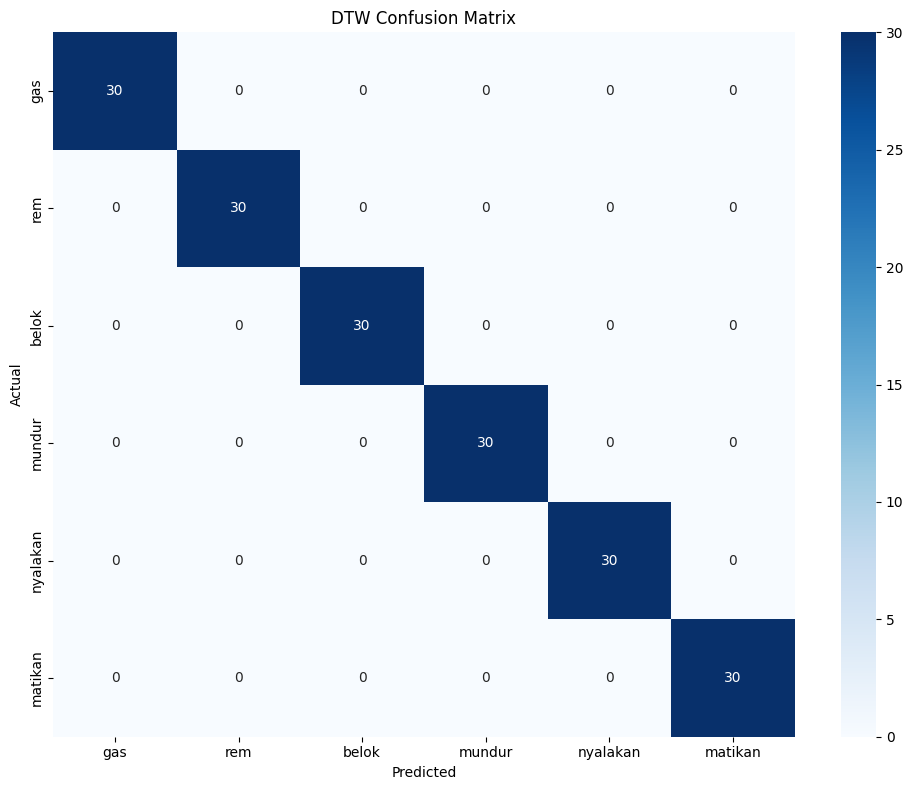

\n📊 Confusion Matrix - HMM


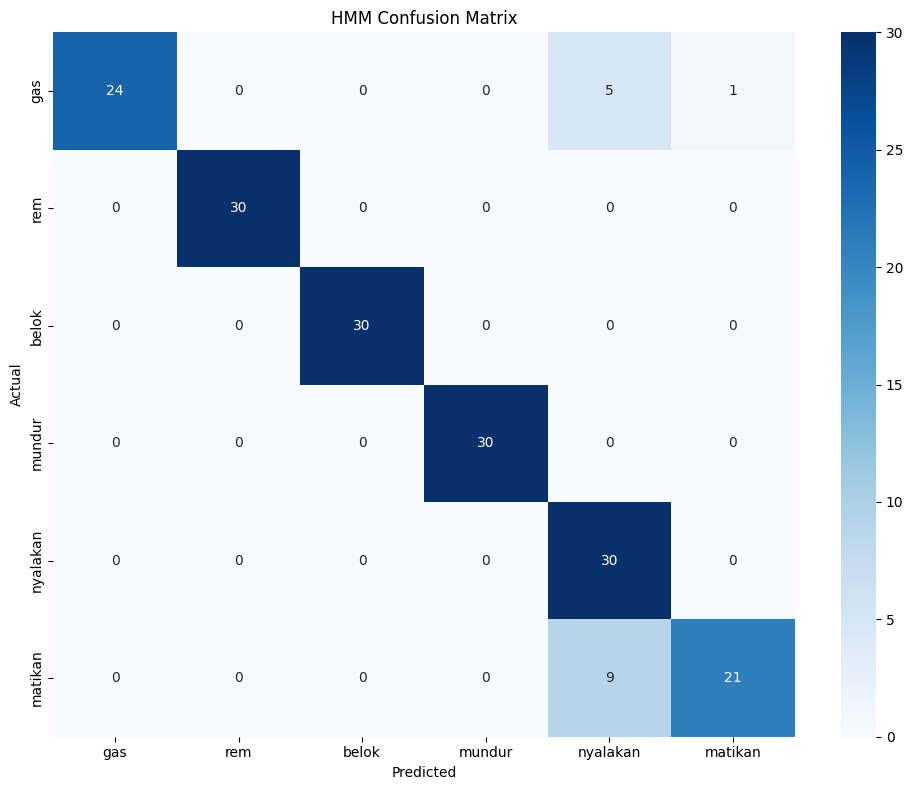

\n📈 Perbandingan Performa DTW vs HMM


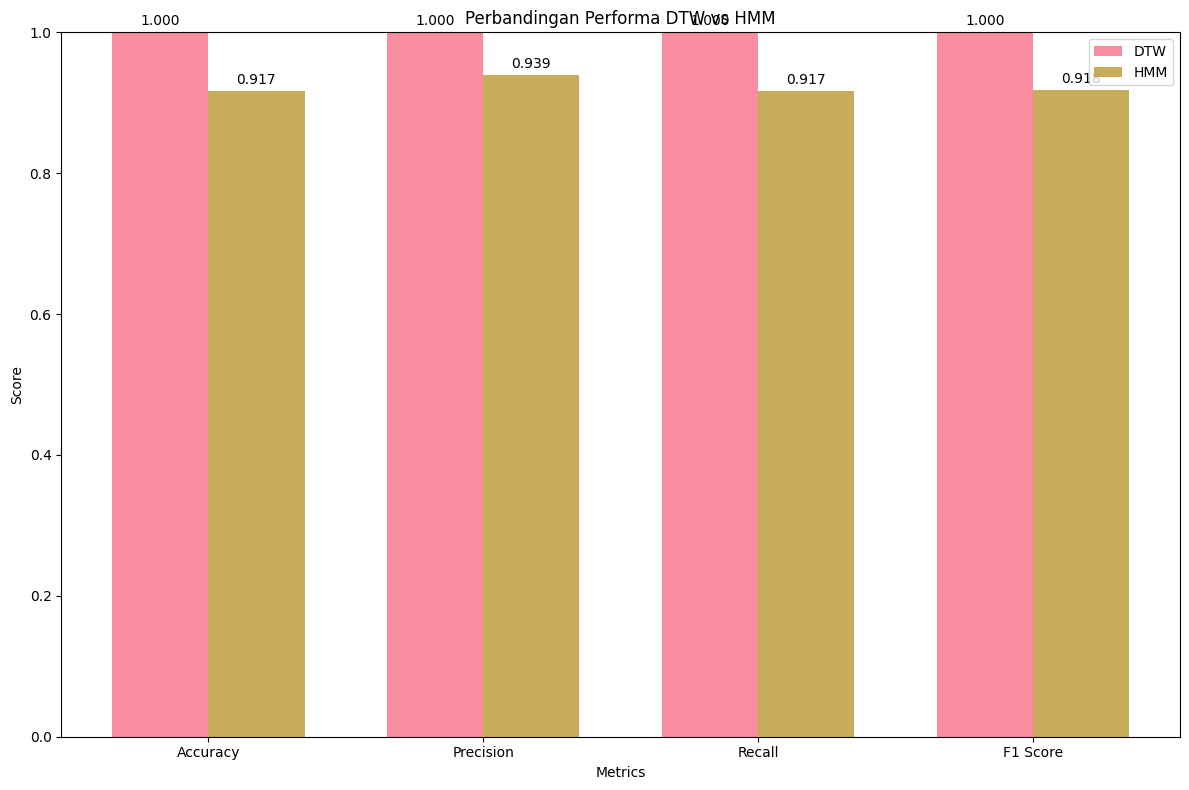

\n🔍 Analisis Detail - DTW


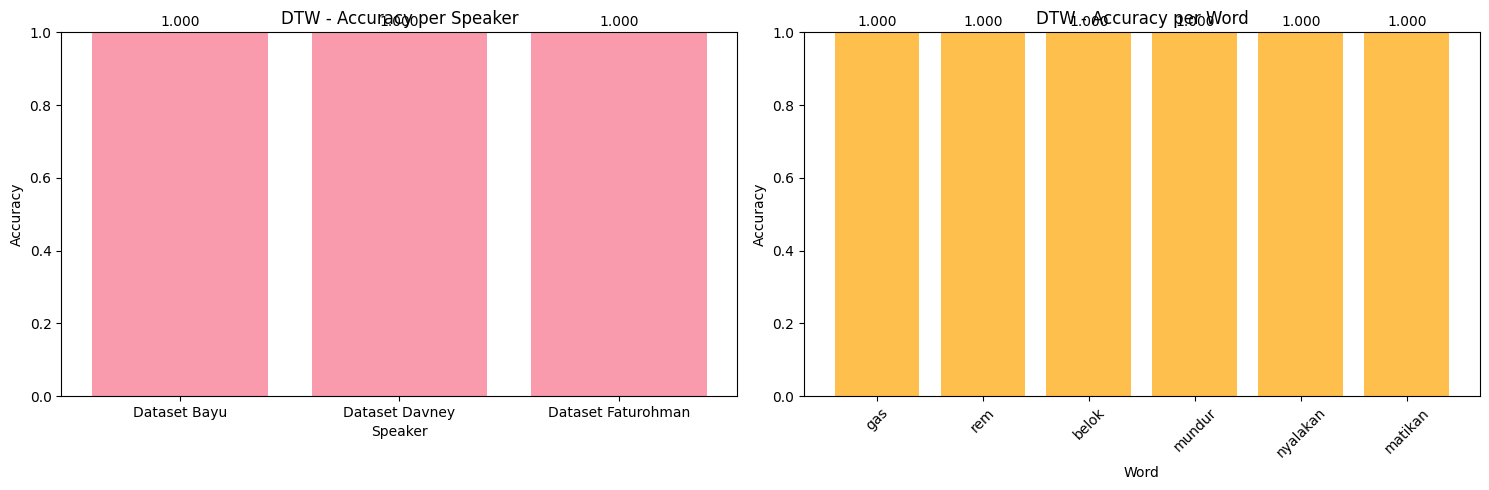

\n🔍 Analisis Detail - HMM


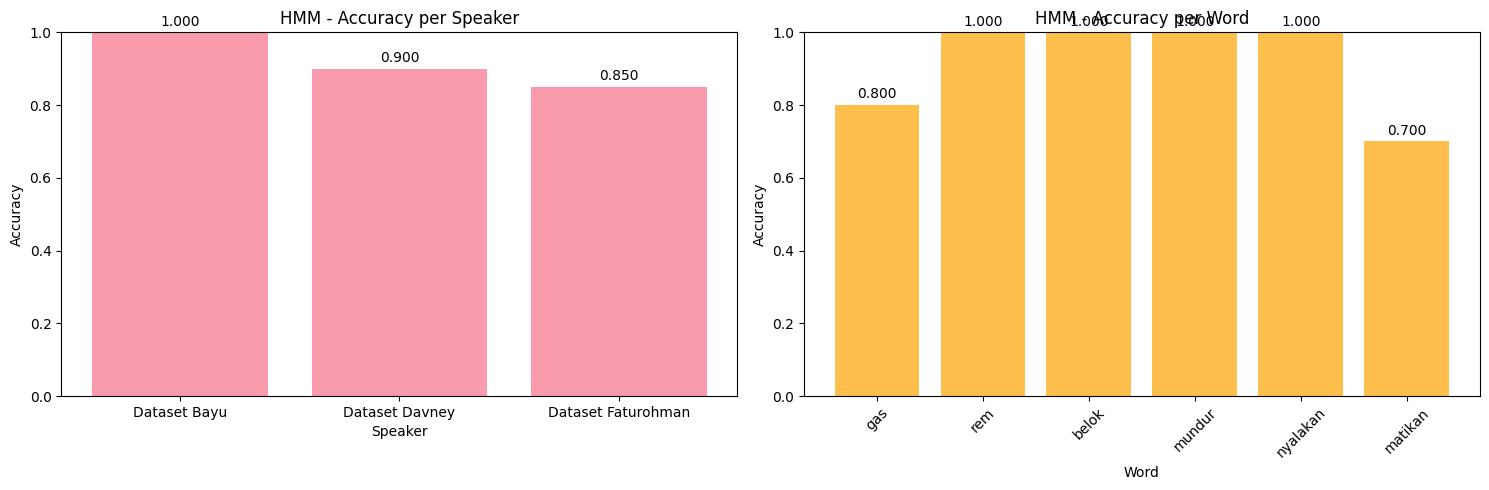

\n📋 LAPORAN KLASIFIKASI DETAIL

📊 DTW Classification Report
              precision    recall  f1-score   support

       belok       1.00      1.00      1.00        30
         gas       1.00      1.00      1.00        30
     matikan       1.00      1.00      1.00        30
      mundur       1.00      1.00      1.00        30
    nyalakan       1.00      1.00      1.00        30
         rem       1.00      1.00      1.00        30

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180


📊 HMM Classification Report
              precision    recall  f1-score   support

       belok       1.00      1.00      1.00        30
         gas       1.00      0.80      0.89        30
     matikan       0.95      0.70      0.81        30
      mundur       1.00      1.00      1.00        30
    nyalakan       0.68      1.00      0.81        30
         rem       1.00      1.00      1.00

In [12]:
# ========================================================================================
# 12. VISUALISASI HASIL
# ========================================================================================

if dtw_results is not None and hmm_results is not None:
    print("🎨 MEMBUAT VISUALISASI HASIL")
    print("=" * 35)
    
    # Confusion Matrix DTW
    print("\\n📊 Confusion Matrix - DTW")
    plot_confusion_matrix(dtw_results['y_true'], dtw_results['y_pred'], 
                         title="DTW Confusion Matrix")
    
    # Confusion Matrix HMM
    print("\\n📊 Confusion Matrix - HMM")
    plot_confusion_matrix(hmm_results['y_true'], hmm_results['y_pred'], 
                         title="HMM Confusion Matrix")
    
    # Perbandingan Performa
    print("\\n📈 Perbandingan Performa DTW vs HMM")
    compare_models_performance(dtw_results, hmm_results)
    
    # Detail Results DTW
    print("\\n🔍 Analisis Detail - DTW")
    plot_detailed_results(dtw_results, title="DTW")
    
    # Detail Results HMM
    print("\\n🔍 Analisis Detail - HMM")
    plot_detailed_results(hmm_results, title="HMM")
    
    # Classification Reports
    print("\\n📋 LAPORAN KLASIFIKASI DETAIL")
    print("=" * 40)
    
    print_classification_report(dtw_results['y_true'], dtw_results['y_pred'], 
                               title="DTW Classification Report")
    
    print_classification_report(hmm_results['y_true'], hmm_results['y_pred'], 
                               title="HMM Classification Report")
    
else:
    print("❌ Tidak dapat membuat visualisasi karena tidak ada hasil evaluasi")

In [13]:
# ========================================================================================
# 13. DEMO QUICK TEST
# ========================================================================================

def quick_test_sample(audio_path, true_word=None):
    """Test cepat dengan satu sample audio"""
    if dtw_model is None or hmm_model is None:
        print("❌ Model belum tersedia untuk testing")
        return
    
    print(f"🎵 Testing audio: {os.path.basename(audio_path)}")
    if true_word:
        print(f"🎯 True word: {true_word}")
    
    print("-" * 40)
    
    # Test dengan DTW
    dtw_pred, dtw_distances = dtw_model.predict(audio_path)
    print(f"🔍 DTW Prediction: {dtw_pred}")
    if dtw_distances:
        print("   DTW Distances:")
        for word, dist in sorted(dtw_distances.items(), key=lambda x: x[1]):
            print(f"     {word}: {dist:.3f}")
    
    # Test dengan HMM
    hmm_pred, hmm_scores = hmm_model.predict(audio_path)
    print(f"\\n🔍 HMM Prediction: {hmm_pred}")
    if hmm_scores:
        print("   HMM Scores:")
        for word, score in sorted(hmm_scores.items(), key=lambda x: x[1], reverse=True):
            print(f"     {word}: {score:.3f}")
    
    # Hasil
    if true_word:
        dtw_correct = "✅" if dtw_pred == true_word else "❌"
        hmm_correct = "✅" if hmm_pred == true_word else "❌"
        print(f"\\n📊 Results:")
        print(f"   DTW: {dtw_correct} {dtw_pred}")
        print(f"   HMM: {hmm_correct} {hmm_pred}")

if dtw_model is not None and hmm_model is not None and available_speakers:
    print("🎪 DEMO QUICK TEST")
    print("=" * 25)
    
    # Ambil beberapa sample untuk demo
    demo_samples = []
    
    # Cari sample dari dataset yang tersedia
    for speaker in available_speakers:
        for word in VOCABULARY:
            if 'training' in dataset and speaker in dataset['training']:
                if word in dataset['training'][speaker] and len(dataset['training'][speaker][word]) > 0:
                    sample_path = dataset['training'][speaker][word][0]  # Ambil sample pertama
                    demo_samples.append((sample_path, word, speaker))
                    break  # Satu sample per speaker cukup untuk demo
        if len(demo_samples) >= 3:  # Batasi demo
            break
    
    if demo_samples:
        print(f"\\n🎵 Testing {len(demo_samples)} sample audio files...")
        print("=" * 50)
        
        for i, (audio_path, true_word, speaker) in enumerate(demo_samples, 1):
            print(f"\\n🎵 DEMO {i}/3 - {speaker}")
            quick_test_sample(audio_path, true_word)
            print()
    else:
        print("❌ Tidak ada sample audio yang tersedia untuk demo")
        
else:
    print("❌ Demo tidak dapat dijalankan:")
    if not available_speakers:
        print("   - Tidak ada speaker yang tersedia")
    if dtw_model is None or hmm_model is None:
        print("   - Model belum di-training")

🎪 DEMO QUICK TEST
\n🎵 Testing 3 sample audio files...
\n🎵 DEMO 1/3 - Dataset Bayu
🎵 Testing audio: Gas bayu 1.wav
🎯 True word: gas
----------------------------------------
🔍 DTW Prediction: gas
   DTW Distances:
     gas: 0.000
     mundur: 5048.120
     belok: 5256.988
     rem: 5700.380
     nyalakan: 5754.137
     matikan: 6073.133
\n🔍 HMM Prediction: gas
   HMM Scores:
     gas: -5465.139
     belok: -5827.811
     nyalakan: -6168.749
     mundur: -6182.717
     rem: -6259.551
     matikan: -6346.175
\n📊 Results:
   DTW: ✅ gas
   HMM: ✅ gas

\n🎵 DEMO 2/3 - Dataset Davney
🎵 Testing audio: Recording (2).wav
🎯 True word: gas
----------------------------------------
🔍 DTW Prediction: gas
   DTW Distances:
     gas: 0.000
     rem: 4212.308
     mundur: 4594.750
     belok: 4691.878
     nyalakan: 5472.368
     matikan: 5789.435
\n🔍 HMM Prediction: nyalakan
   HMM Scores:
     nyalakan: -6716.081
     gas: -6744.720
     rem: -6820.727
     matikan: -6827.098
     belok: -6965.033
     

In [14]:
# ========================================================================================
# 14. SAVE RESULTS DAN SUMMARY
# ========================================================================================

if 'dtw_results' in locals() and 'hmm_results' in locals() and dtw_results is not None and hmm_results is not None:
    print("💾 MENYIMPAN HASIL EVALUASI")
    print("=" * 35)
    
    # Buat folder results jika belum ada
    os.makedirs('results', exist_ok=True)
    
    # Simpan hasil evaluasi
    save_results(dtw_results, hmm_results, 'results/speech_recognition_results.pkl')
    
    print("\n📊 RINGKASAN FINAL:")
    print("=" * 30)
    print(f"✅ Dataset yang digunakan: {', '.join(available_speakers)}")
    if missing_datasets:
        print(f"❌ Dataset yang diabaikan: {', '.join(missing_datasets)}")
    print(f"✅ Vocabulary: {', '.join(VOCABULARY)}")
    print(f"✅ Total training samples: {total_training_files}")
    
    if 'has_testing_data' in locals() and has_testing_data:
        print(f"✅ Total testing samples: {total_testing_files}")
    else:
        print("⚠️ Menggunakan training data untuk testing")
    
    print(f"\n🏆 HASIL TERBAIK:")
    best_model = "DTW" if dtw_results['accuracy'] > hmm_results['accuracy'] else "HMM"
    best_accuracy = max(dtw_results['accuracy'], hmm_results['accuracy'])
    print(f"   Model: {best_model}")
    print(f"   Accuracy: {best_accuracy:.3f}")
    
    if best_model == "DTW":
        print(f"   Precision: {dtw_results['precision']:.3f}")
        print(f"   Recall: {dtw_results['recall']:.3f}")
        print(f"   F1-Score: {dtw_results['f1_score']:.3f}")
    else:
        print(f"   Precision: {hmm_results['precision']:.3f}")
        print(f"   Recall: {hmm_results['recall']:.3f}")
        print(f"   F1-Score: {hmm_results['f1_score']:.3f}")
    
    print("\n💾 File yang disimpan:")
    print("   📁 models/dtw_model.pkl - DTW model")
    print("   📁 models/hmm_model.pkl - HMM model") 
    print("   📁 results/speech_recognition_results.pkl - Hasil evaluasi")
    print("   📁 results/speech_recognition_results.txt - Summary text")
    
else:
    print("❌ Tidak dapat menyimpan hasil karena evaluasi belum dilakukan")
    print("   📁 Pastikan dataset tersedia untuk training dan testing")

print("\n🎉 EKSPERIMEN SELESAI!")
print("=" * 25)

if 'available_speakers' in locals() and available_speakers:
    print("🎯 Proyek Speech Recognition DTW vs HMM berhasil diselesaikan!")
    print(f"📊 Menggunakan dataset dari: {', '.join(available_speakers)}")
else:
    print("⚠️ Eksperimen tidak dapat berjalan karena tidak ada dataset")

# Pesan khusus untuk dataset yang tidak tersedia
if 'missing_datasets' in locals() and missing_datasets:
    print(f"\n⚠️ CATATAN: Dataset yang tidak tersedia: {', '.join(missing_datasets)}")
    print("   🚫 Sistem TIDAK membuat dataset otomatis")
    print("   📝 Untuk eksperimen yang lebih komprehensif, silakan:")
    
    for missing in missing_datasets:
        print(f"   1. Buat folder 'data/training/{missing}/'")
        print(f"   2. Buat folder 'data/testing/{missing}/'")
        print(f"   3. Tambahkan subfolder untuk setiap kata: {', '.join(VOCABULARY)}")
        print(f"   4. Isi dengan file audio .wav")
    
    print("   5. Jalankan ulang notebook ini")

print("\n🔒 PRINSIP DATASET:")
print("   ✅ Hanya menggunakan dataset yang sudah ada")
print("   ❌ TIDAK membuat dataset otomatis/sintetis")
print("   📁 Menggunakan struktur folder yang disediakan user")
print("   👤 User bertanggung jawab menyediakan dataset")

💾 MENYIMPAN HASIL EVALUASI
💾 Results saved to results/speech_recognition_results.pkl
📄 Text summary saved to results/speech_recognition_results.txt

📊 RINGKASAN FINAL:
✅ Dataset yang digunakan: Dataset Bayu, Dataset Davney, Dataset Faturohman
✅ Vocabulary: gas, rem, belok, mundur, nyalakan, matikan
✅ Total training samples: 180
⚠️ Menggunakan training data untuk testing

🏆 HASIL TERBAIK:
   Model: DTW
   Accuracy: 1.000
   Precision: 1.000
   Recall: 1.000
   F1-Score: 1.000

💾 File yang disimpan:
   📁 models/dtw_model.pkl - DTW model
   📁 models/hmm_model.pkl - HMM model
   📁 results/speech_recognition_results.pkl - Hasil evaluasi
   📁 results/speech_recognition_results.txt - Summary text

🎉 EKSPERIMEN SELESAI!
🎯 Proyek Speech Recognition DTW vs HMM berhasil diselesaikan!
📊 Menggunakan dataset dari: Dataset Bayu, Dataset Davney, Dataset Faturohman

🔒 PRINSIP DATASET:
   ✅ Hanya menggunakan dataset yang sudah ada
   ❌ TIDAK membuat dataset otomatis/sintetis
   📁 Menggunakan struktur fo

## 📋 Informasi Tambahan

### Struktur Dataset yang Diharapkan
```
data/
├── training/
│   ├── Dataset Bayu/
│   │   ├── gas/
│   │   ├── rem/
│   │   ├── belok/
│   │   ├── mundur/
│   │   ├── nyalakan/
│   │   └── matikan/
│   ├── Dataset Davney/
│   │   ├── gas/
│   │   ├── rem/
│   │   ├── belok/
│   │   ├── mundur/
│   │   ├── nyalakan/
│   │   └── matikan/
│   └── Dataset Faturohman/
│       ├── gas/
│       ├── rem/
│       ├── belok/
│       ├── mundur/
│       ├── nyalakan/
│       └── matikan/
└── testing/
    ├── Dataset Bayu/
    ├── Dataset Davney/
    └── Dataset Faturohman/
```

### File Audio Requirements
- **Format**: `.wav`
- **Sampling Rate**: 22050 Hz (otomatis di-resample)
- **Channels**: Mono (otomatis dikonversi)
- **Durasi**: Bebas (akan dinormalisasi)

### Algoritma yang Diimplementasi

#### 1. Dynamic Time Warping (DTW)
- **Fitur**: MFCC (13 coefficients)
- **Metode**: Template matching dengan jarak Euclidean
- **Library**: `fastdtw` untuk optimasi kecepatan

#### 2. Hidden Markov Models (HMM)
- **Fitur**: Enhanced features (MFCC + Delta + Delta-Delta)
- **Model**: Gaussian HMM dengan 5 states
- **Library**: `hmmlearn`

### Metrik Evaluasi
- **Accuracy**: Persentase prediksi yang benar
- **Precision**: TP / (TP + FP) - per kelas, weighted average
- **Recall**: TP / (TP + FN) - per kelas, weighted average  
- **F1-Score**: Harmonic mean of precision and recall

### Output Files
- `models/dtw_model.pkl`: Trained DTW model
- `models/hmm_model.pkl`: Trained HMM model
- `results/speech_recognition_results.pkl`: Detailed evaluation results
- `results/speech_recognition_results.txt`: Summary report

### Troubleshooting

#### Dataset Not Found
Jika muncul pesan "Dataset tidak ditemukan":
1. Pastikan folder `data/training/` dan `data/testing/` ada
2. Pastikan nama folder speaker sesuai: `Dataset Bayu`, `Dataset Davney`, `Dataset Faturohman`
3. Pastikan setiap folder speaker berisi subfolder untuk setiap kata
4. Pastikan file audio berformat `.wav`

#### Package Installation Issues
Jika ada error saat install package:
```bash
pip install librosa scikit-learn seaborn matplotlib fastdtw hmmlearn soundfile
```

#### Memory Issues
Jika terjadi memory error:
1. Kurangi jumlah file audio per kata
2. Turunkan sampling rate di konfigurasi
3. Kurangi n_components untuk HMM